In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

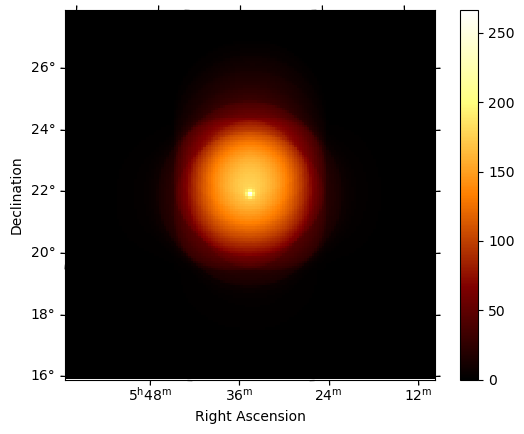

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1"
)

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Varying the Exposure

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

# energy independent method: pm 10% for reconstructed energy
shift_neg = -0.085
shift_pos = -0.5
shift_cor = 0.0

tilt_neg = -0.0 # -0.015 # 1e-25 for computational purposes -> covmatrix "1/0"
tilt_pos = 2.0 # 0.015
tilt_cor = 0.0

In [5]:
def sum_e(x):
    return x.sum(axis=2).sum(axis=1)

In [6]:
sys_d_cor = sys_dataset(dataset_asimov, shift_cor, tilt_cor, False)
dataset_cor = sys_d_cor.create_dataset()

sys_d_neg = sys_dataset(dataset_asimov, shift_neg, tilt_neg, False)
dataset_neg = sys_d_neg.create_dataset()

sys_d_pos = sys_dataset(dataset_asimov, shift_pos, tilt_pos, False)
dataset_pos = sys_d_pos.create_dataset()

#print(dataset_cor)

In [7]:
exposure_pos = dataset_pos.exposure
exposure_neg = dataset_neg.exposure

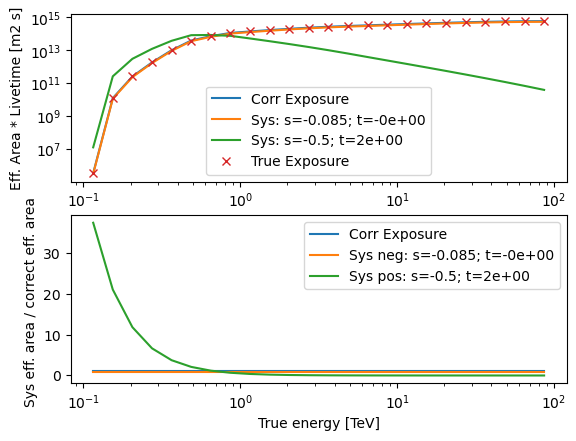

In [8]:
fig,ax = plt.subplots(2,1)

exposure_standard = dataset_asimov.exposure.data.sum(axis=2).sum(axis=1)
exposure_e = dataset_cor.exposure.data.sum(axis=2).sum(axis=1)

ax[0].plot(true_energy, exposure_e, label = "Corr Exposure")
ax[0].plot(true_energy, sum_e(exposure_neg.data), 
           label = f'Sys: s={shift_neg:.2}; t={tilt_neg:.1}')
ax[0].plot(true_energy, sum_e(exposure_pos.data), 
           label = f'Sys: s={shift_pos:.2}; t={tilt_pos:.1}')
ax[0].plot(true_energy, exposure_standard, 'x', label = "True Exposure")

ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel("True energy [TeV]")
ax[0].set_ylabel(f"Eff. Area * Livetime [{dataset_asimov.exposure.unit}]")
ax[0].legend()

ax[1].plot(true_energy, exposure_e/exposure_standard, label = "Corr Exposure")
ax[1].plot(true_energy, sum_e(exposure_neg.data)/exposure_e,
           label = f'Sys neg: s={shift_neg:.2}; t={tilt_neg:.1}')
ax[1].plot(true_energy, sum_e(exposure_pos.data)/ exposure_e, 
           label = f'Sys pos: s={shift_pos:.2}; t={tilt_pos:.1}')

#ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel("True energy [TeV]")
ax[1].set_ylabel(f"Sys eff. area / correct eff. area ")
ax[1].legend()

fig.savefig("plots/1b_exposure_example.pdf")

C:\Users\yt02izug\AppData\Local\Temp\ipykernel_2936\127695946.py:23: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred/npred, label = "Model ")
C:\Users\yt02izug\AppData\Local\Temp\ipykernel_2936\127695946.py:24: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred_neg/npred,
C:\Users\yt02izug\AppData\Local\Temp\ipykernel_2936\127695946.py:26: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(true_energy, npred_pos/npred,


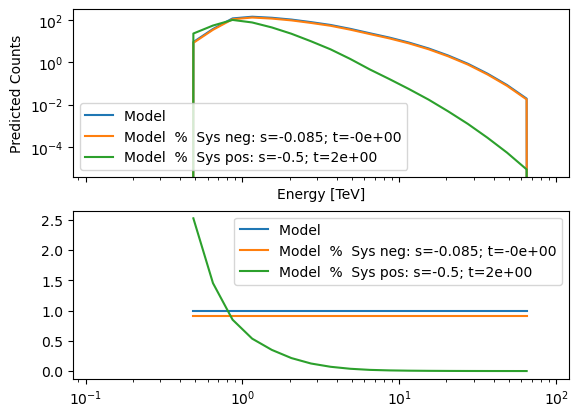

In [9]:
fig,ax = plt.subplots(2,1, sharex = True)

energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV

npred =     dataset_cor.npred_signal().data.sum(axis = 2).sum(axis= 1) #or (dataset_cor.counts - dataset_cor.background)
npred_neg = dataset_neg.npred_signal().data.sum(axis = 2).sum(axis= 1)
npred_pos = dataset_pos.npred_signal().data.sum(axis = 2).sum(axis= 1)


ax[0].plot(true_energy, npred, label = "Model ")
ax[0].plot(true_energy, npred_neg, 
         label =f"Model  %  Sys neg: s={shift_neg:.2}; t={tilt_neg:.1}")
ax[0].plot(true_energy, npred_pos,  
         label =f"Model  %  Sys pos: s={shift_pos:.2}; t={tilt_pos:.1}")

         
ax[0].loglog()
ax[0].legend()
ax[0].set_xlabel("Energy [TeV]")
ax[0].set_ylabel("Predicted Counts")


ax[1].plot(true_energy, npred/npred, label = "Model ")
ax[1].plot(true_energy, npred_neg/npred, 
         label =f"Model  %  Sys neg: s={shift_neg:.2}; t={tilt_neg:.1}")
ax[1].plot(true_energy, npred_pos/npred,  
         label =f"Model  %  Sys pos: s={shift_pos:.2}; t={tilt_pos:.1}")

ax[1].legend()
ax[1].set_xscale('log')
fig = plt.gcf()
fig.savefig("plots/1b_counts.pdf")

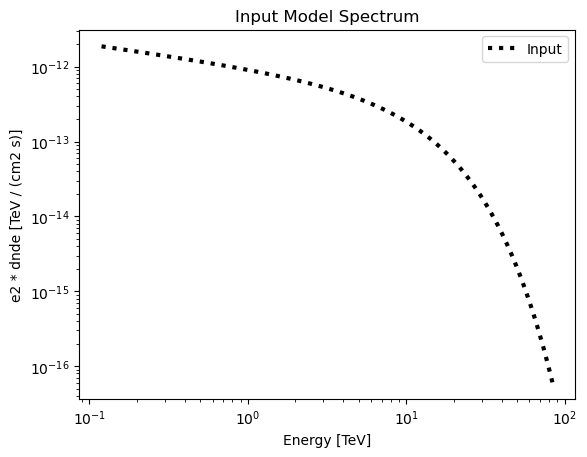

In [10]:
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
#dataset_cor.models['Source'].spectral_model.plot(energy_bounds, label = "Spectrum")
#dataset_neg.models['Source'].spectral_model.plot(energy_bounds, label = "")
#dataset_pos.models['Source'].spectral_model.plot(energy_bounds, label = "")
dataset_asimov.models['Source'].spectral_model.plot(energy_bounds, energy_power = 2,
                                label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')
plt.title("Input Model Spectrum")
plt.legend()

In [11]:
%%time
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_cor])
fit_neg = Fit(store_trace=False)
result_neg = fit_neg.run([dataset_neg])
fit_pos = Fit(store_trace=False)
result_pos = fit_pos.run([dataset_pos])
print(result_pos)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 461
	total stat : -752490.77

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: total: 11 s
Wall time: 11 s


In [12]:
datasets_short = [dataset_neg, dataset_cor, dataset_pos]
print("Best Fit amplitude")
amplitudes = []
m = dataset_asimov.models['Source']
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes.append((value, error))
    print(f'{value} pm {error}')
print()
print("Best Fit Index")
indices = []
m = dataset_asimov.models['Source']
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models['Source']
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms = []
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms.append((value, error))
print()   
    
print("Best Fit Lambda")
lambdas = []
value = dataset_asimov.models.parameters['lambda_'].value 
error = dataset_asimov.models.parameters['lambda_'].error
lambdas.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.models.parameters['lambda_'].value 
    error = d.models.parameters['lambda_'].error
    print(f'{value} pm {error}')
    lambdas.append((value, error))
    
    
with open('data/1b_norms.yaml', 'w') as file:
    documents = yaml.dump(norms, file)
with open('data/1b_amplitudes.yaml', 'w') as file:
    documents = yaml.dump(amplitudes, file)
with open('data/1b_indices.yaml', 'w') as file:
    documents = yaml.dump(indices, file)
with open('data/1b_lambdas.yaml', 'w') as file:
    documents = yaml.dump(lambdas, file)
    
dataset_neg.models.write("data/1b_model_neg.yml", overwrite= True)
dataset_pos.models.write("data/1b_model_pos.yml", overwrite= True)
dataset_cor.models.write("data/1b_model_cor.yml", overwrite= True)

Best Fit amplitude
====
Input
1e-12 pm 0
====
1.0954689061062002e-12 pm 1.3239954889257042e-13
1e-12 pm 1.2341778557925224e-13
2.0113478527436202e-12 pm 2.476904217077806e-13

Best Fit Index
====
Input
2.3 pm 0
====
2.2999592032758365 pm 0.2862316223601866
2.3 pm 0.15723862830492105
0.29848988643319296 pm 0.15713616459163585

Best Fit bkg Norm
====
Input
1.0 pm 0
====
0.9999847366459713 pm 0.0014788152539472826
1.0 pm 0.0020630035071734884
0.9999988747854746 pm 0.0020665088964897916

Best Fit Lambda
====
Input
0.1 pm 0
====
0.10097471371211869 pm 0.08502539799271132
0.1 pm 0.04762308948792854
0.09951671730028455 pm 0.04686523111031731


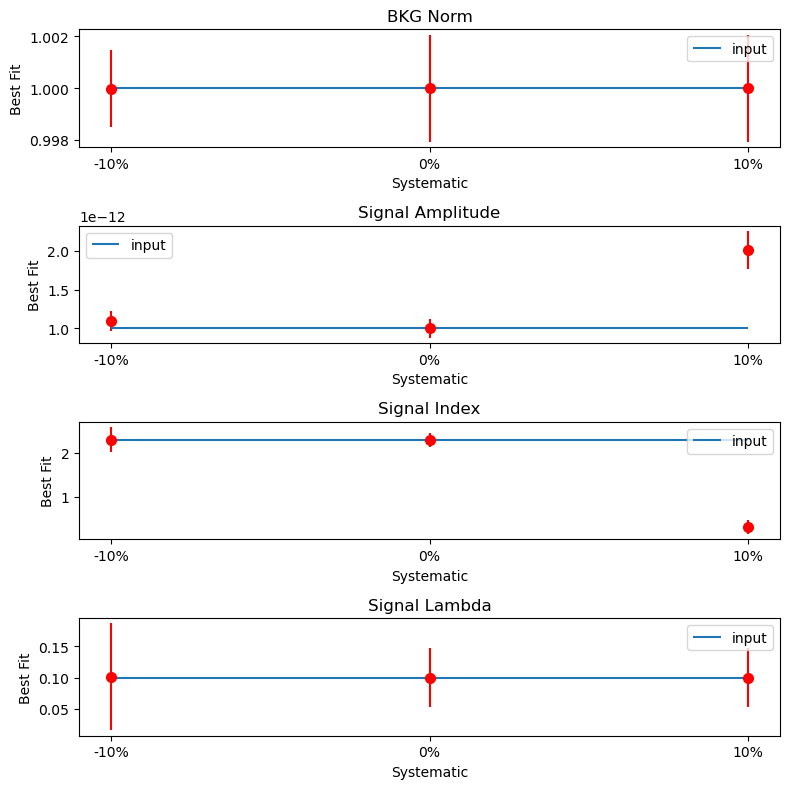

In [13]:
fig, axs = plt.subplots(4,1, figsize=(8,8))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")
axs[3].set_title("Signal Lambda")


labels = ['-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[0].hlines( norms[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[1].hlines( amplitudes[0][0], 1, 3, label = "input")

for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[2].hlines( indices[0][0], 1, 3, label = "input")

for i, a in enumerate(lambdas[1:]):
    axs[3].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red', markersize=7)
axs[3].hlines( lambdas[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    a.legend(); 
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels)

plt.tight_layout()    
fig.savefig("plots/1b_best_fit_parameters_standard.pdf")   


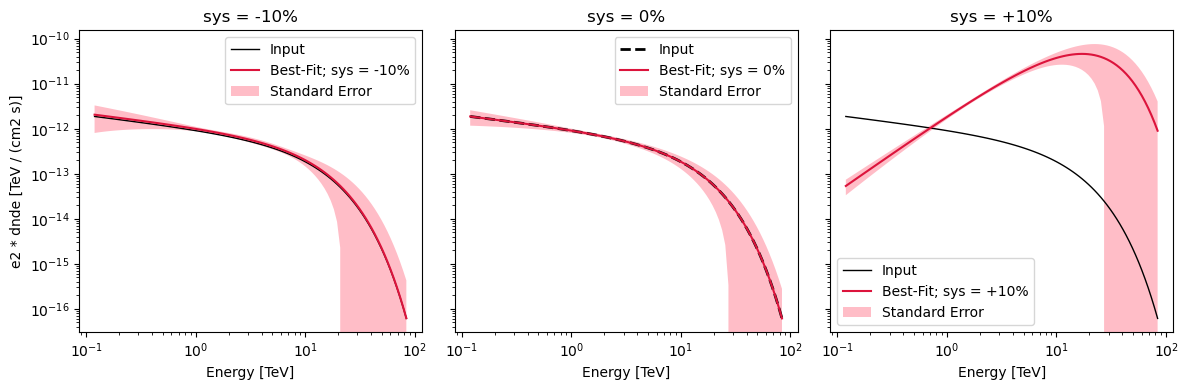

In [14]:
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV

fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )

dataset_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )

dataset_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/1b_spectrum_standard.pdf")

## Dependency of Errors on shift & tilt

### Varying Shift with Fixed Tilt

In [51]:
%%time
amplitude_shift = []
index_shift = []
lambda_shift = []
norm_shift = []
errors_amplitude_shift = []
errors_index_shift = []
errors_lambda_shift = []
errors_norm_shift = []

amplitude_shift_fail = []
index_shift_fail = []
lambda_shift_fail = []
norm_shift_fail = []
errors_amplitude_shift_fail = []
errors_index_shift_fail = []
errors_lambda_shift_fail = []
errors_norm_shift_fail = []

tilt_fixed = 0.0

for i, shift in enumerate(np.linspace(-0.11, 0.11, 45)):
    print('shift', i, '=', shift)
    sys_d = sys_dataset(dataset_asimov, shift, tilt_fixed, False)
    dataset_shift = sys_d.create_dataset()
    fit_shift = Fit(store_trace=False)
    result_shift = fit_shift.run([dataset_shift])
    if result_shift.success:
        amplitude_shift.append((shift, dataset_shift.models.parameters['amplitude'].value))
        index_shift.append((shift, dataset_shift.models.parameters['index'].value))
        lambda_shift.append((shift, dataset_shift.models.parameters['lambda_'].value))
        norm_shift.append((shift, dataset_shift.models.parameters['norm'].value))

        errors_amplitude_shift.append((shift, dataset_shift.models.parameters['amplitude'].error))
        errors_index_shift.append((shift, dataset_shift.models.parameters['index'].error))
        errors_lambda_shift.append((shift, dataset_shift.models.parameters['lambda_'].error))
        errors_norm_shift.append((shift, dataset_shift.models.parameters['norm'].error))
    else:
        print('Fail')
        amplitude_shift_fail.append((shift, dataset_shift.models.parameters['amplitude'].value))
        index_shift_fail.append((shift, dataset_shift.models.parameters['index'].value))
        lambda_shift_fail.append((shift, dataset_shift.models.parameters['lambda_'].value))
        norm_shift_fail.append((shift, dataset_shift.models.parameters['norm'].value))

        errors_amplitude_shift_fail.append((shift, dataset_shift.models.parameters['amplitude'].error))
        errors_index_shift_fail.append((shift, dataset_shift.models.parameters['index'].error))
        errors_lambda_shift_fail.append((shift, dataset_shift.models.parameters['lambda_'].error))
        errors_norm_shift_fail.append((shift, dataset_shift.models.parameters['norm'].error))
    
    
    #print(dataset_shift.models.parameters['amplitude'].error)
    #print(dataset_shift.models.parameters['index'].error)

In [52]:
fig, ax = plt.subplots(2,4, figsize=(16,8))

ax[0][0].scatter(*zip(*amplitude_shift), label='amplitude')  
ax[0][1].scatter(*zip(*index_shift), label='index')
ax[0][2].scatter(*zip(*lambda_shift), label='lambda')
ax[0][3].scatter(*zip(*norm_shift), label='bkg norm')

ax[1][0].scatter(*zip(*errors_amplitude_shift), label='amplitude error')  
ax[1][1].scatter(*zip(*errors_index_shift), label='index error')
ax[1][2].scatter(*zip(*errors_lambda_shift), label='lambda error')
ax[1][3].scatter(*zip(*errors_norm_shift), label='bkg norm error')

if bool(amplitude_shift_fail):
    ax[0][0].scatter(*zip(*amplitude_shift_fail), label='amplitude fit failed', color='tab:orange')  
    ax[0][1].scatter(*zip(*index_shift_fail), label='index fit failed', color='tab:orange')
    ax[0][2].scatter(*zip(*lambda_shift_fail), label='lambda fit failed', color='tab:orange')
    ax[0][3].scatter(*zip(*norm_shift_fail), label='norm fit failed', color='tab:orange')

    ax[1][0].scatter(*zip(*errors_amplitude_shift_fail), label='amplitude error fit failed', color='tab:orange')  
    ax[1][1].scatter(*zip(*errors_index_shift_fail), label='index error fit failed', color='tab:orange')
    ax[1][2].scatter(*zip(*errors_lambda_shift_fail), label='lambda error fit failed', color='tab:orange')
    ax[1][3].scatter(*zip(*errors_norm_shift_fail), label='norm error fit failed', color='tab:orange')

ax[0][0].set_xlabel('shift');ax[0][1].set_xlabel('shift');ax[0][2].set_xlabel('shift');ax[0][3].set_xlabel('shift')
ax[1][0].set_xlabel('shift');ax[1][1].set_xlabel('shift');ax[1][2].set_xlabel('shift');ax[1][3].set_xlabel('shift')
ax[0][0].legend();ax[0][1].legend();ax[0][2].legend();ax[0][3].legend()
ax[1][0].legend();ax[1][1].legend();ax[1][2].legend();ax[1][3].legend()
plt.suptitle(f'Varying Shift with Fixed Tilt (tilt = {tilt_fixed})')
plt.tight_layout()
plt.show()

### Varying Tilt with Fixed Shift

In [53]:
%%time
amplitude_tilt = []
index_tilt = []
lambda_tilt = []
norm_tilt = []
errors_amplitude_tilt = []
errors_index_tilt = []
errors_lambda_tilt = []
errors_norm_tilt = []

amplitude_tilt_fail = []
index_tilt_fail = []
lambda_tilt_fail = []
norm_tilt_fail = []
errors_amplitude_tilt_fail = []
errors_index_tilt_fail = []
errors_lambda_tilt_fail = []
errors_norm_tilt_fail = []

shift_fixed = -0.085

for i, tilt in enumerate(np.linspace(-0.11, 0.11, 45)):
    print('tilt', i, '=', tilt)
    sys_d = sys_dataset(dataset_asimov, shift_fixed, tilt, False)
    dataset_tilt = sys_d.create_dataset()
    fit_tilt = Fit(store_trace=False)
    result_tilt = fit_tilt.run([dataset_tilt])
    if result_tilt.success:
        #print(result_tilt.success)
        amplitude_tilt.append((tilt, dataset_tilt.models.parameters['amplitude'].value))
        index_tilt.append((tilt, dataset_tilt.models.parameters['index'].value))
        lambda_tilt.append((tilt, dataset_tilt.models.parameters['lambda_'].value))
        norm_tilt.append((tilt, dataset_tilt.models.parameters['norm'].value))

        errors_amplitude_tilt.append((tilt, dataset_tilt.models.parameters['amplitude'].error))
        errors_index_tilt.append((tilt, dataset_tilt.models.parameters['index'].error))
        errors_lambda_tilt.append((tilt, dataset_tilt.models.parameters['lambda_'].error))
        errors_norm_tilt.append((tilt, dataset_tilt.models.parameters['norm'].error))
    else:
        print('Fail')
        amplitude_tilt_fail.append((tilt, dataset_tilt.models.parameters['amplitude'].value))
        index_tilt_fail.append((tilt, dataset_tilt.models.parameters['index'].value))
        lambda_tilt_fail.append((tilt, dataset_tilt.models.parameters['lambda_'].value))
        norm_tilt_fail.append((tilt, dataset_tilt.models.parameters['norm'].value))

        errors_amplitude_tilt_fail.append((tilt, dataset_tilt.models.parameters['amplitude'].error))
        errors_index_tilt_fail.append((tilt, dataset_tilt.models.parameters['index'].error))
        errors_lambda_tilt_fail.append((tilt, dataset_tilt.models.parameters['lambda_'].error))
        errors_norm_tilt_fail.append((tilt, dataset_tilt.models.parameters['norm'].error))
    
    
    #print(dataset_tilt.models.parameters['amplitude'].error)
    #print(dataset_tilt.models.parameters['index'].error)

In [54]:
fig, ax = plt.subplots(2,4, figsize=(16,8))

ax[0][0].scatter(*zip(*amplitude_tilt), label='amplitude')  
ax[0][1].scatter(*zip(*index_tilt), label='index')
ax[0][2].scatter(*zip(*lambda_tilt), label='lambda')
ax[0][3].scatter(*zip(*norm_tilt), label='bkg norm')

ax[1][0].scatter(*zip(*errors_amplitude_tilt), label='amplitude error')  
ax[1][1].scatter(*zip(*errors_index_tilt), label='index error')
ax[1][2].scatter(*zip(*errors_lambda_tilt), label='lambda error')
ax[1][3].scatter(*zip(*errors_norm_tilt), label='bkg norm error')

if bool(amplitude_tilt_fail):
    ax[0][0].scatter(*zip(*amplitude_tilt_fail), label='amplitude fit failed', color='tab:orange')  
    ax[0][1].scatter(*zip(*index_tilt_fail), label='index fit failed', color='tab:orange')
    ax[0][2].scatter(*zip(*lambda_tilt_fail), label='lambda fit failed', color='tab:orange')
    ax[0][3].scatter(*zip(*norm_tilt_fail), label='bkg norm fit failed', color='tab:orange')

    ax[1][0].scatter(*zip(*errors_amplitude_tilt_fail), label='amplitude error fit failed', color='tab:orange')  
    ax[1][1].scatter(*zip(*errors_index_tilt_fail), label='index error fit failed', color='tab:orange')
    ax[1][2].scatter(*zip(*errors_lambda_tilt_fail), label='lambda error fit failed', color='tab:orange')
    ax[1][3].scatter(*zip(*errors_norm_tilt_fail), label='bkg norm error fit failed', color='tab:orange')

ax[0][0].set_xlabel('tilt');ax[0][1].set_xlabel('tilt');ax[0][2].set_xlabel('tilt');ax[0][3].set_xlabel('tilt')
ax[1][0].set_xlabel('tilt');ax[1][1].set_xlabel('tilt');ax[1][2].set_xlabel('tilt');ax[1][3].set_xlabel('tilt')
ax[0][0].legend();ax[0][1].legend();ax[0][2].legend();ax[0][3].legend()
ax[1][0].legend();ax[1][1].legend();ax[1][2].legend();ax[1][3].legend()
plt.suptitle(f'Varying Tilt with Fixed Shift (shift = {shift_fixed})')
plt.tight_layout()
plt.show()

### Varying Shift and Tilt

In [31]:
%%time

compute = True

amplitude_3d = []
index_3d = []
lambda_3d = []
norm_3d = []
errors_amplitude_3d = []
errors_index_3d = []
errors_lambda_3d = []
errors_norm_3d = []

amplitude_3d_fail = []
index_3d_fail = []
lambda_3d_fail = []
norm_3d_fail = []
errors_amplitude_3d_fail = []
errors_index_3d_fail = []
errors_lambda_3d_fail = []
errors_norm_3d_fail = []

if compute:
    for i, shift in enumerate(np.linspace(-0.11, 0.11, 45)):

        for j, tilt in enumerate(np.linspace(-0.075, 0.075, 31)):
            #print(shift, tilt)
            sys_d = sys_dataset(dataset_asimov, shift, tilt, False)
            dataset_3d = sys_d.create_dataset()
            fit = Fit(store_trace=False)
            result = fit.run([dataset_3d])
            
            if result.success:
                amplitude_3d.append((shift, tilt, dataset_3d.models.parameters['amplitude'].value))
                index_3d.append((shift, tilt, dataset_3d.models.parameters['index'].value))
                lambda_3d.append((shift, tilt, dataset_3d.models.parameters['lambda_'].value))
                norm_3d.append((shift, tilt, dataset_3d.models.parameters['norm'].value))

                errors_amplitude_3d.append((shift, tilt, dataset_3d.models.parameters['amplitude'].error))
                errors_index_3d.append((shift, tilt, dataset_3d.models.parameters['index'].error))
                errors_lambda_3d.append((shift, tilt, dataset_3d.models.parameters['lambda_'].error))
                errors_norm_3d.append((shift, tilt, dataset_3d.models.parameters['norm'].error))
            else:
                print('Fail')
                amplitude_3d_fail.append((shift, tilt, dataset_3d.models.parameters['amplitude'].value))
                index_3d_fail.append((shift, tilt, dataset_3d.models.parameters['index'].value))
                lambda_3d_fail.append((shift, tilt, dataset_3d.models.parameters['lambda_'].value))
                norm_3d_fail.append((shift, tilt, dataset_3d.models.parameters['norm'].value))

                errors_amplitude_3d_fail.append((shift, tilt, dataset_3d.models.parameters['amplitude'].error))
                errors_index_3d_fail.append((shift, tilt, dataset_3d.models.parameters['index'].error))
                errors_lambda_3d_fail.append((shift, tilt, dataset_3d.models.parameters['lambda_'].error)) 
                errors_norm_3d_fail.append((shift, tilt, dataset_3d.models.parameters['norm'].error))

KeyboardInterrupt: 

In [20]:
print(errors_index_3d_fail)

[]


<IPython.core.display.Javascript object>


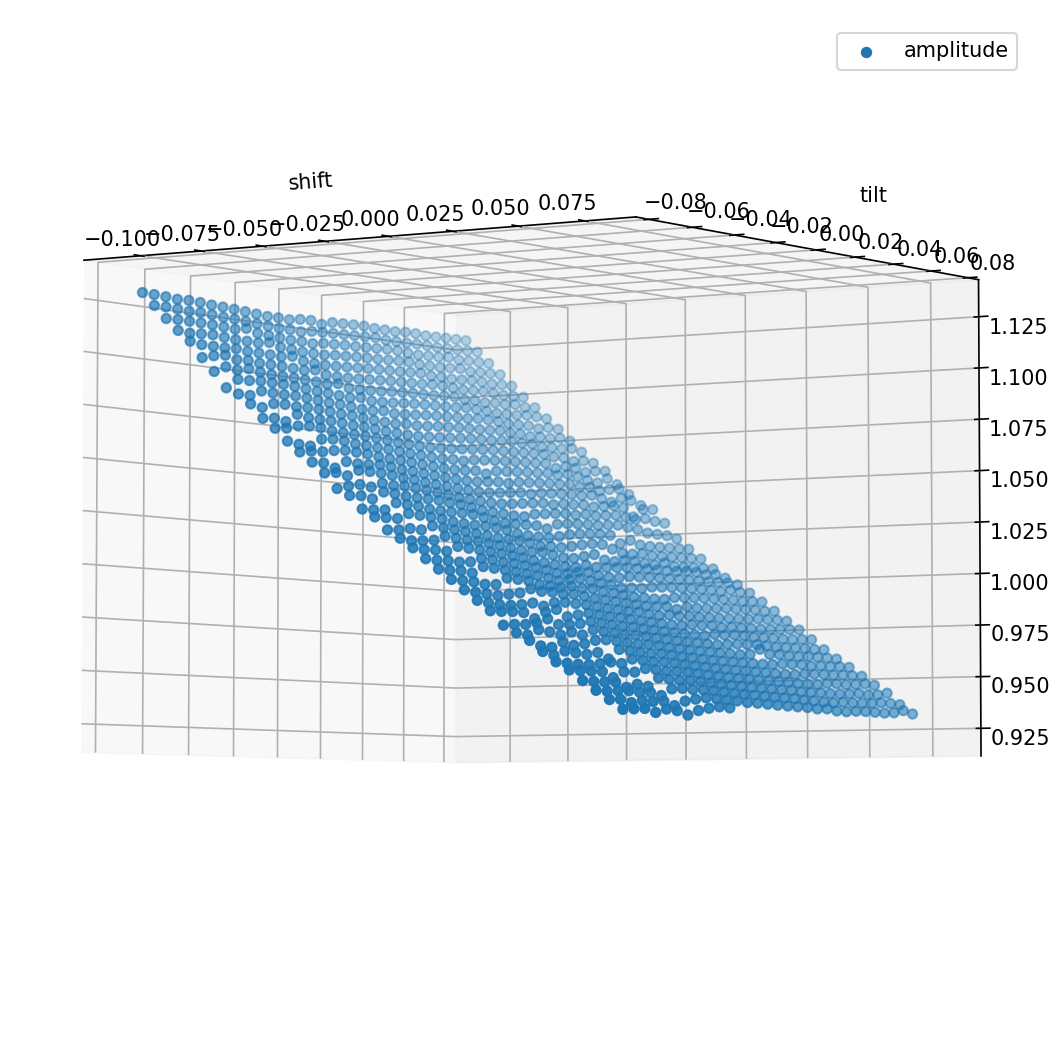

In [34]:
%matplotlib notebook
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection = '3d')

ax.scatter3D(*zip(*amplitude_3d), label='amplitude') 
if bool(errors_amplitude_3d_fail):
    ax.scatter3D(*zip(*amplitude_3d_fail), label='amplitude fit failed', color='tab:orange') 
ax.view_init(3,315)
#ax.set_zlim3d(1.1e-13, 1.4e-13)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('amplitude')
ax.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


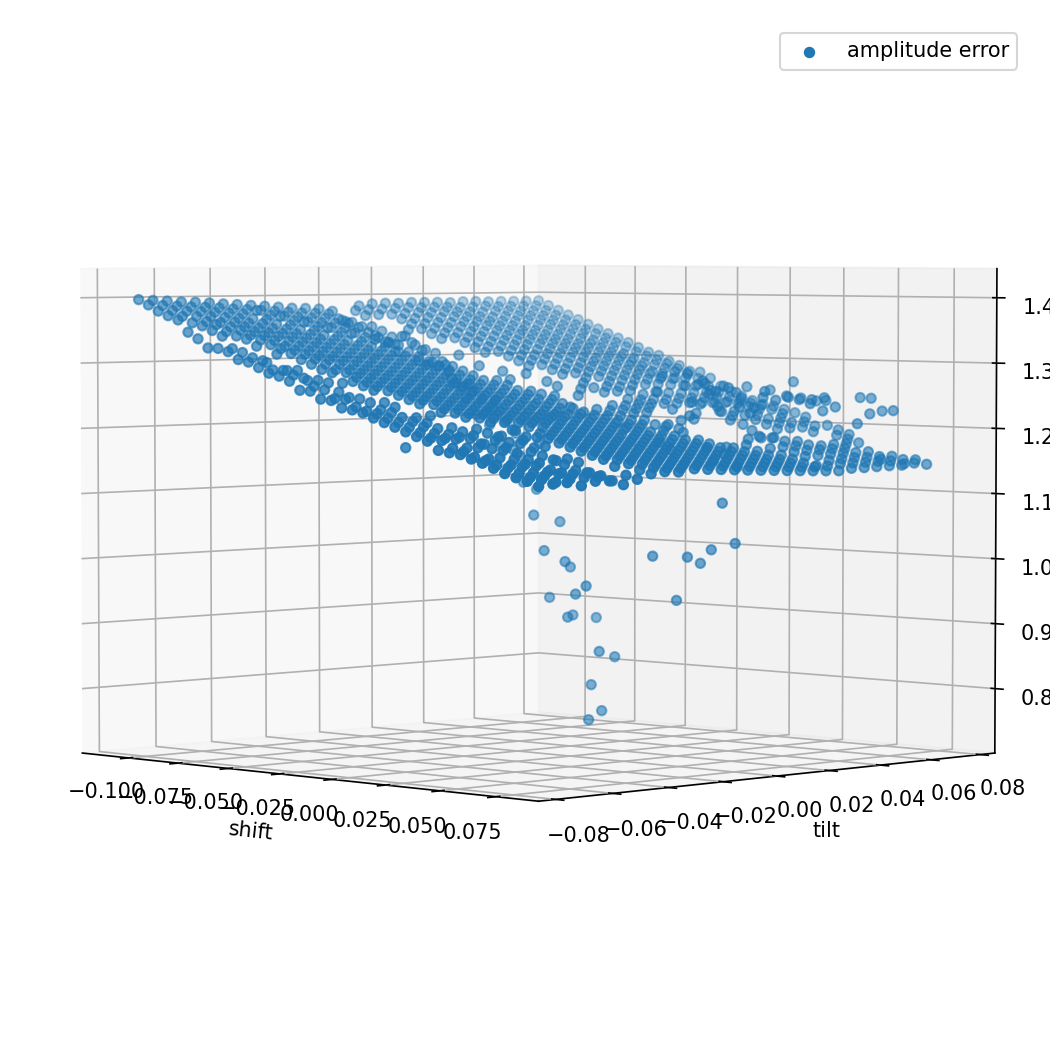

In [35]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection = '3d')

ax.scatter3D(*zip(*errors_amplitude_3d), label='amplitude error') 
if bool(errors_amplitude_3d_fail):
    ax.scatter3D(*zip(*errors_amplitude_3d_fail), label='amplitude error fit failed', color='tab:orange') 
ax.view_init(3,315)
#ax.set_zlim3d(1.1e-13, 1.4e-13)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('amplitude error')
ax.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


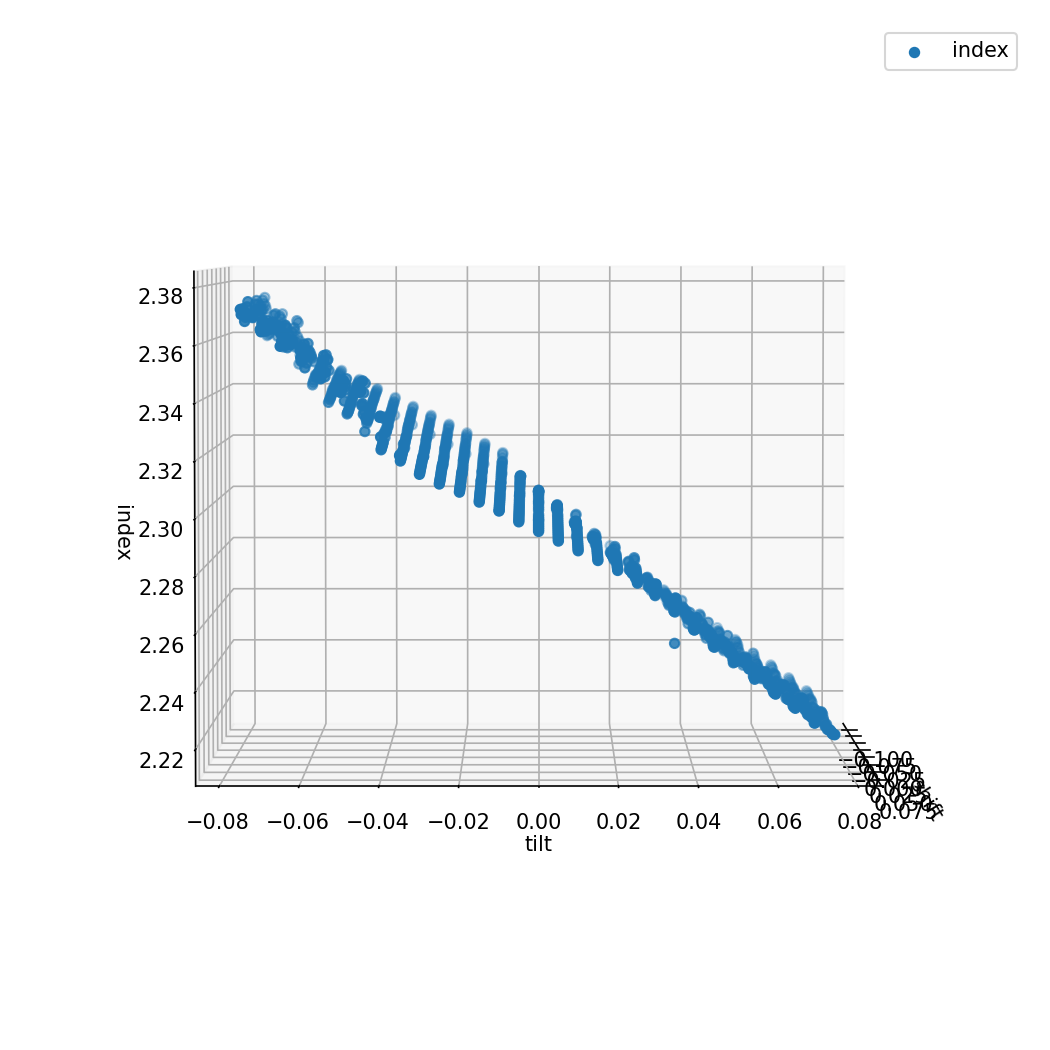

In [36]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')

ax.scatter3D(*zip(*index_3d), label='index') 
if bool(errors_index_3d_fail):
    ax.scatter3D(*zip(*errors_index_3d_fail), label='index fit failed', color='tab:orange') 
ax.view_init(3,0)
#ax.set_zlim3d(0.1565,0.1595)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('index')
ax.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


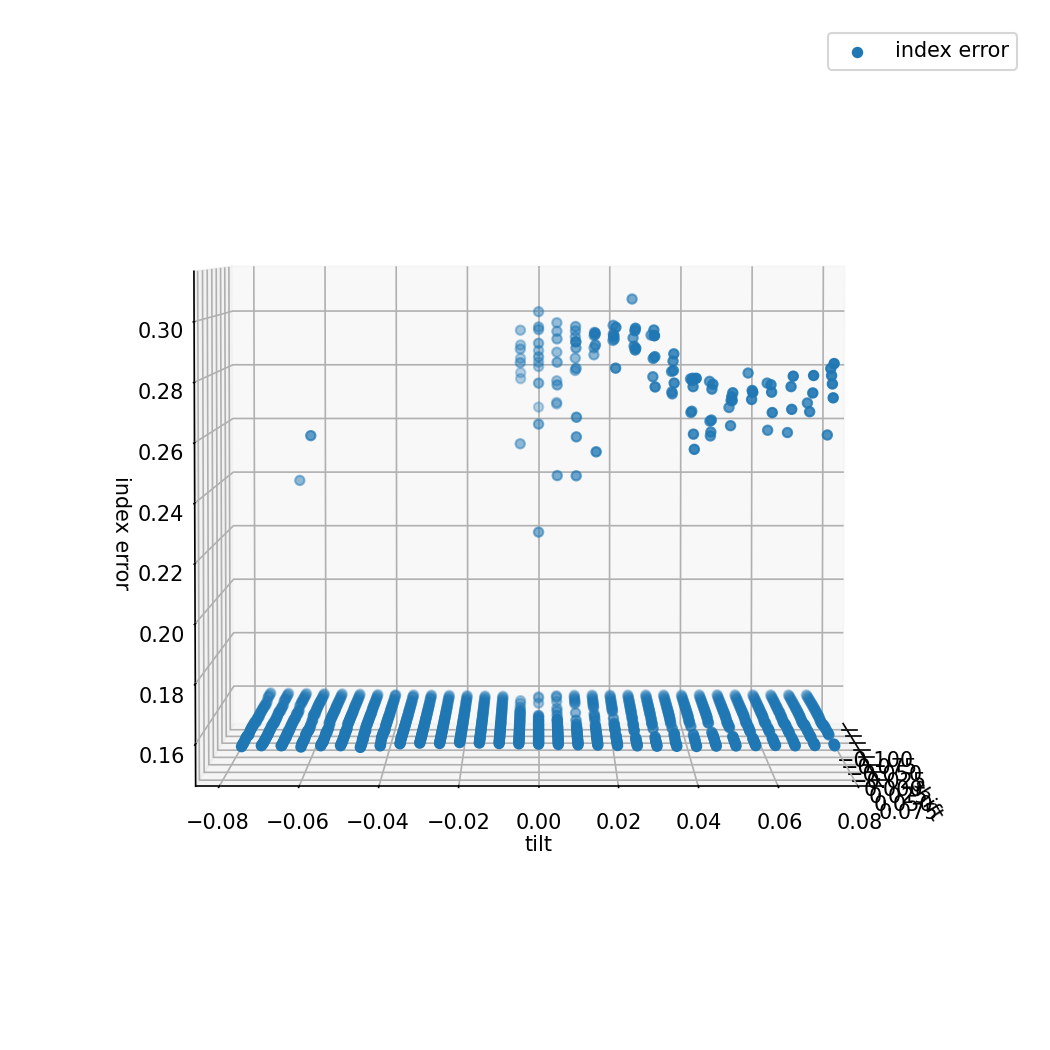

In [37]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')

ax.scatter3D(*zip(*errors_index_3d), label='index error') 
if bool(errors_index_3d_fail):
    ax.scatter3D(*zip(*errors_index_3d_fail), label='index error fit failed', color='tab:orange') 
ax.view_init(3,0)
#ax.set_zlim3d(0.1565,0.1595)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('index error')
ax.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


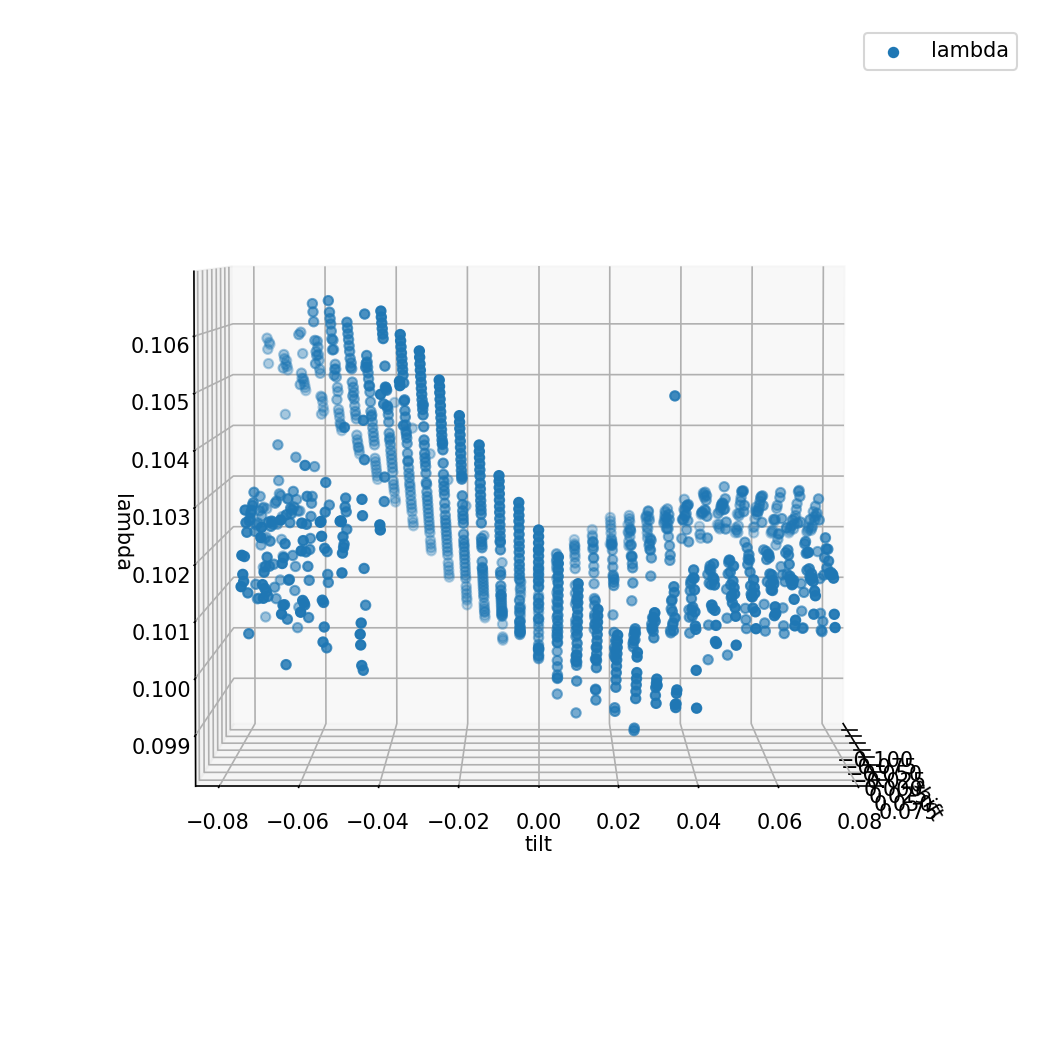

In [38]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')

ax.scatter3D(*zip(*lambda_3d), label='lambda') 
if bool(errors_lambda_3d_fail):
    ax.scatter3D(*zip(*lambda_3d_fail), label='lambda fit failed', color='tab:orange')
ax.view_init(3,0)
#ax.set_zlim3d(0.0465,0.0490)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('lambda')
ax.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


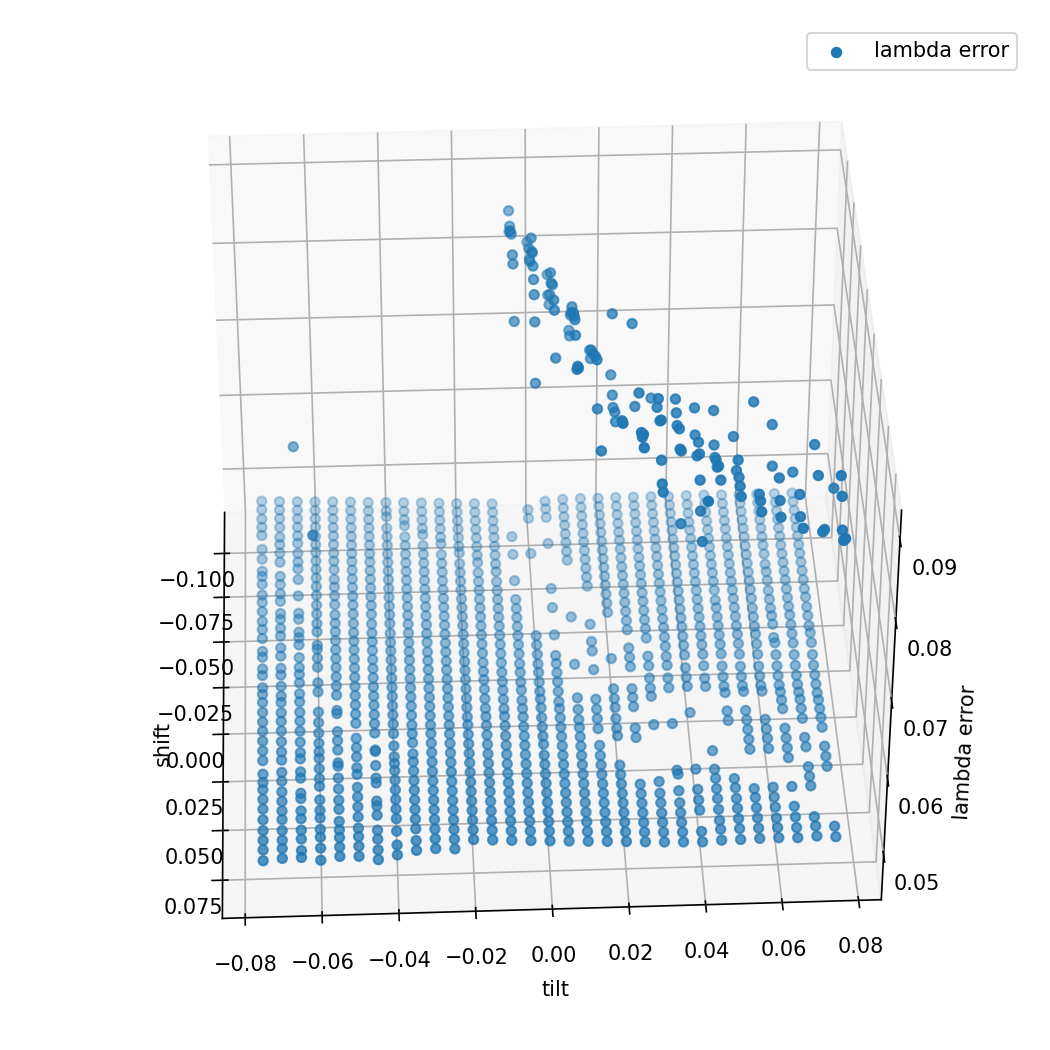

In [43]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')

ax.scatter3D(*zip(*errors_lambda_3d), label='lambda error') 
if bool(errors_lambda_3d_fail):
    ax.scatter3D(*zip(*errors_lambda_3d_fail), label='lambda error fit failed', color='tab:orange')
ax.view_init(3,0)
#ax.set_zlim3d(0.0465,0.0490)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('lambda error')
ax.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


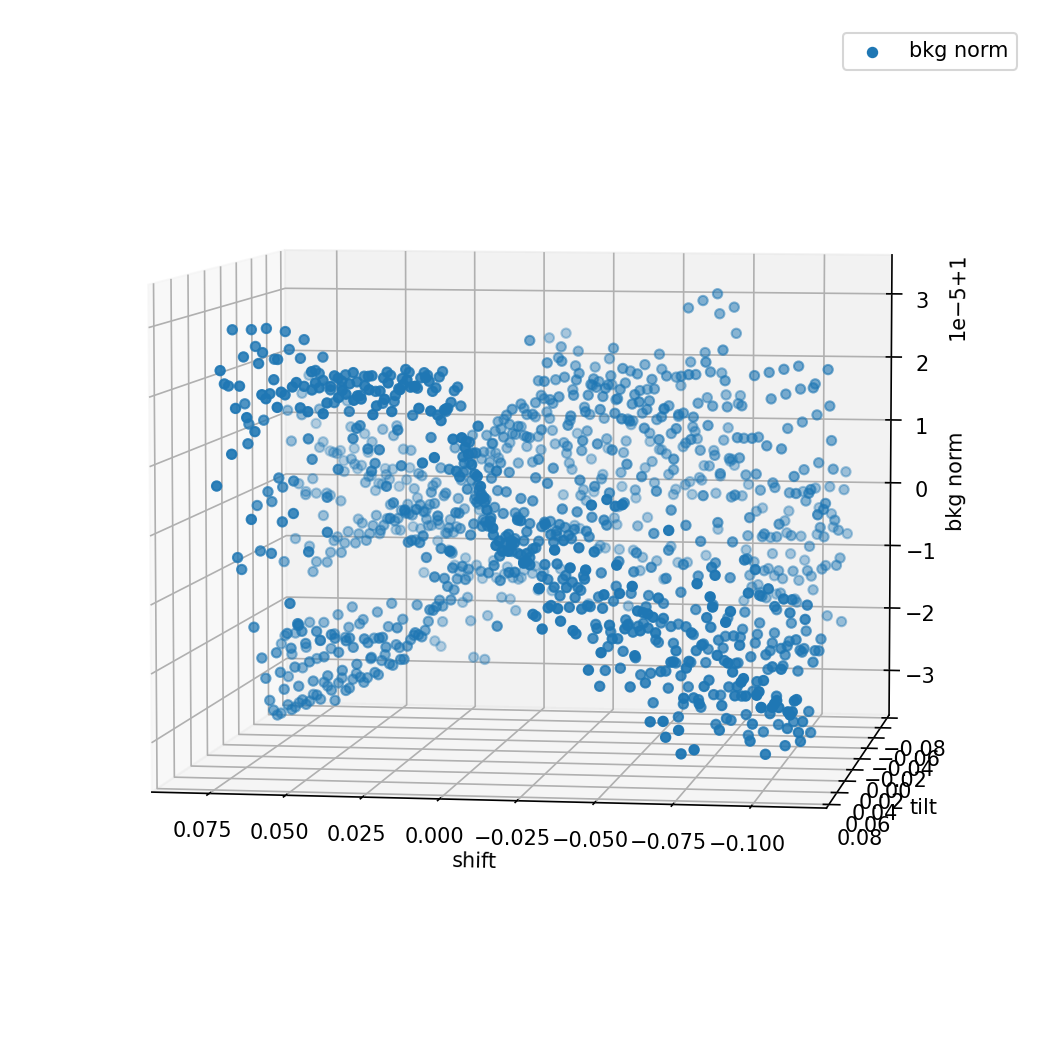

In [42]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')

ax.scatter3D(*zip(*norm_3d), label='bkg norm') 
if bool(errors_norm_3d_fail):
    ax.scatter3D(*zip(*errors_norm_3d_fail), label='bkg norm fit failed', color='tab:orange') 
ax.view_init(3,0)
#ax.set_zlim3d(0.1565,0.1595)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('bkg norm')
ax.legend()
plt.tight_layout()
plt.show()

In [56]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')

ax.scatter3D(*zip(*errors_norm_3d), label='bkg norm error') 
if bool(errors_norm_3d_fail):
    ax.scatter3D(*zip(*errors_norm_3d_fail), label='bkg norm error fit failed', color='tab:orange')
ax.view_init(3,270)
#ax.set_zlim3d(0.0465,0.0490)
ax.set_xlabel('shift')
ax.set_ylabel('tilt')
ax.set_zlabel('bkg norm error')
ax.legend()
plt.tight_layout()
plt.show()